# From pyABC to BayesFlow
## Markov Jump Process: Reaction Network
_Author: Jonas Arruda_

In the following, we fit stochastic chemical reaction kinetics with Approximate Bayesian Computation (ABC) and show how to transfer the workflow to `BayesFlow`. Any model written in an ABC framework can be easily transferred to `BayesFlow`. The main difference is that `BayesFlow` enables *amortized inference*, allowing us to instantly infer parameters from new data sets without further training.

In ABC, inference is tailored for a single dataset. For both we need to specify a simulator and priors over the parameters. While in ABC we also need to specify a distance function between observation and simulation (and for higher dimensional problems also summary statistics), in `BayesFlow` we only need to specify an adapter that maps the simulator output to the output of a neural `Approximator`. After training, we can validate the computational faithfulness of the trained approximator using various Bayesian metrics, such as simulation-based calibration (SBC). This is typically not feasible with ABC, as we would have to repeat the same expensive approximation loop for every new data set.

For this example, we need to install [pyABC](https://github.com/icb-dcm/pyabc), which is our go-to library for ABC. The example is taken from [the documentation](https://pyabc.readthedocs.io/en/latest/examples/chemical_reaction.html). This tutorial starts with the ABC implementation and then demonstrates how to easily switch to BayesFlow. Readers familiar with pyABC can fast-forward to the second part of the notebook.

In [ ]:
# Install if not already installed
%pip install pyabc -q

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from pyabc import RV, Distribution
from pyabc import ABCSMC
from pyabc import weighted_statistics
from pyabc.populationstrategy import AdaptivePopulationSize
from pyabc.visualization import plot_kde_1d
from pyabc.visualization import plot_sample_numbers

### Simulator

We consider a Markov jump process model $m_1$ for conversion of (chemical) species $X$ to species $Y$:

$$
   X + Y \xrightarrow{k} 2Y.
$$

The model is equipped with a single rate parameter $k$. To simulate this model, we define a simple Gillespie simulator:

In [ ]:
def helper(x, pre, c):
    return (x**pre).prod(1) * c


def gillespie(x, c, pre, post, max_t):
    """
    Gillespie simulation

    Parameters
    ----------

    x: 1D array of size n_species
        The initial numbers.

    c: 1D array of size n_reactions
        The reaction rates.

    pre: array of size n_reactions x n_species
        What is to be consumed.

    post: array of size n_reactions x n_species
        What is to be produced

    max_t: int
        Timulate up to time max_t

    Returns
    -------
    t, X: 1d array, 2d array
        t: The time points.
        X: The history of the species.
           ``X.shape == (t.size, x.size)``

    """
    t = 0
    t_store = [t]
    x_store = [x.copy()]
    S = post - pre

    while t < max_t:
        h_vec = helper(x, pre, c)
        h0 = h_vec.sum()
        if h0 == 0:
            break
        delta_t = np.random.exponential(1 / h0)
        # no reaction can occur any more
        if not np.isfinite(delta_t):
            t_store.append(max_t)
            x_store.append(x)
            break
        reaction = np.random.choice(c.size, p=h_vec / h0)
        t = t + delta_t
        x = x + S[reaction]

        t_store.append(t)
        x_store.append(x)

    return np.array(t_store), np.array(x_store)

Next, we define the model in terms of the initial molecule numbers $x_0$, an array ``pre`` which determines what is to be consumed (the LHS of the reaction equations) and an array ``post`` which determines what is to be produced (the RHS of the reaction equations). Further, we define that the simulation time should not exceed ``MAX_T`` seconds.

The simulation starts with initial concentrations $X=40$ and $Y=3$.
The reaction $X + Y \rightarrow 2Y$ is encoded in ``pre = [[1, 1]]`` and ``post = [[0, 2]]``.

In [3]:
MAX_T = 0.1

class StochasticModel:
    __name__ = "StochasticModel"
    x0 = np.array([40, 3])  # Initial molecule numbers
    pre = np.array([[1, 1]], dtype=int)
    post = np.array([[0, 2]])

    def __call__(self, par):
        rate = np.array([np.power(10, par["rate"])])
        t, X = gillespie(
            self.x0, rate, self.pre, self.post, MAX_T
        )
        return {"t": t, "X": X}

Below, we draw one stochastic simulation from the model (the ``Observation``) and visualize it:

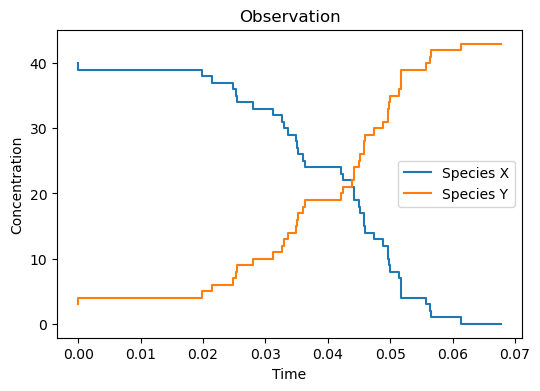

In [ ]:
true_rate = np.log10(2.3)
observations = StochasticModel()({"rate": true_rate})
fig, axes = plt.subplots(ncols=1, tight_layout=True, figsize=(6, 4))
axes.step(observations["t"], observations["X"])
axes.legend(["Species X", "Species Y"])
axes.set_xlabel("Time")
axes.set_ylabel("Concentration")
axes.set_title("Observation")
plt.show()

We observe that species $X$ is converted into species $Y$.

In `pyABC`, we need to define a distance function as $L_1$ norm of two trajectories, evaluated at 20 time points. This is not needed for `BayesFlow`.

$$
  \mathrm{distance}(X_1, X_2) =
     \frac{1}{N}\sum_{n=1}^{N} 
           \left  |X_1(t_n) -X_2(t_n) 
           \right|, \quad t_n = \frac{n}{N}T, \quad  N=20 \,.
$$

We only consider the concentration of species $Y$ in the distance calculation and not every time point which we simulate is actually observed. In code, this translates to:

In [5]:
N_TEST_TIMES = 20
t_test_times = np.linspace(0, MAX_T, N_TEST_TIMES)

def distance(x, y):
    xt_ind = np.searchsorted(x["t"], t_test_times) - 1
    yt_ind = np.searchsorted(y["t"], t_test_times) - 1
    error = (
        np.absolute(x["X"][:, 1][xt_ind] - y["X"][:, 1][yt_ind]).sum()
        / t_test_times.size
    )
    return error

We choose a uniform prior over the interval $[-1, 2]$ in $\log_{10}$ space for the single rate parameter:

In [ ]:
prior = Distribution(rate=RV("uniform", -1, 2))

We initialize the `ABCSMC` class passing the model, the priors and the distance function.
There are many more hyperparameters that can be set, but we will stick to the defaults besides using an adaptive population size to reduce the number of simulations. We initialize a new ABC run, taking as observed data the one generated by the model with the true parameter.


In [ ]:
abc = ABCSMC(
    models=StochasticModel(),
    parameter_priors=prior,
    distance_function=distance,
    population_size=AdaptivePopulationSize(500, 0.15),
)

# generate a temporary SQLite DB
abc_id = abc.new("sqlite:////tmp/mjp.db", observations)

ABC.Sampler INFO: Parallelize sampling on 10 processes.
ABC.History INFO: Start <ABCSMC id=26, start_time=2025-02-15 19:38:22>


In [14]:
abc_history = abc.run(minimum_epsilon=0.7, max_nr_populations=15)

ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 1.30000000e+01.
ABC INFO: Accepted: 500 / 989 = 5.0556e-01, ESS: 5.0000e+02.
ABC.Adaptation INFO: Change nr particles 500 -> 71
ABC INFO: t: 1, eps: 8.57500000e+00.
ABC INFO: Accepted: 71 / 161 = 4.4099e-01, ESS: 7.0788e+01.
ABC.Adaptation INFO: Change nr particles 71 -> 63
ABC INFO: t: 2, eps: 4.90000000e+00.
ABC INFO: Accepted: 63 / 171 = 3.6842e-01, ESS: 6.0655e+01.
ABC.Adaptation INFO: Change nr particles 63 -> 53
ABC INFO: t: 3, eps: 3.77371152e+00.
ABC INFO: Accepted: 53 / 180 = 2.9444e-01, ESS: 4.6748e+01.
ABC.Adaptation INFO: Change nr particles 53 -> 52
ABC INFO: t: 4, eps: 2.90000000e+00.
ABC INFO: Accepted: 52 / 480 = 1.0833e-01, ESS: 5.0802e+01.
ABC.Adaptation INFO: Change nr particles 52 -> 53
ABC INFO: t: 5, eps: 2.40000000e+00.
ABC INFO: Accepted: 53 / 739 = 7.1719e-02, ESS: 1.2840e+01.
ABC.Adaptation INFO: Change nr particles 53 -> 55
ABC INFO: t: 6, eps: 1.85639982e+00.
ABC INFO: Accepted: 55 / 3509 = 1.5674e-02

We then inspect the distribution of the rate parameter:

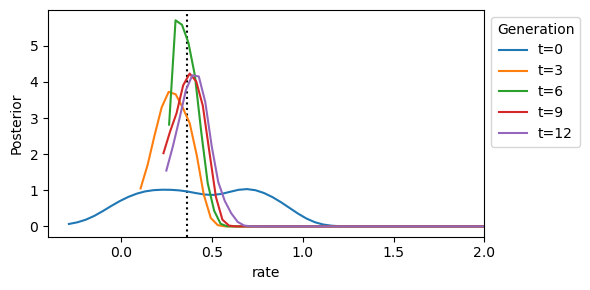

In [ ]:
fig, axes = plt.subplots(1, tight_layout=True)
fig.set_size_inches((6, 3))
axes.axvline(true_rate, color="black", linestyle="dotted")
for t in range(0, abc_history.n_populations, 3):
    df, w = abc_history.get_distribution(m=0, t=t)
    plot_kde_1d(
        df,
        w,
        "rate",
        xmax=2,
        ax=axes,
        label=f"t={t}",
    )
axes.legend(title="Generation", loc="upper left", bbox_to_anchor=(1, 1))
plt.show()

We can see that the posterior distribution is centered around the true rate parameter value. So the ABC run was successful for this single dataset.

## Transitioning to BayesFlow

We choose a backend for the neural network, in this case we use `torch`.

In [ ]:
import os
if "KERAS_BACKEND" not in os.environ:
    # set this to "torch", "tensorflow", or "jax"
    os.environ["KERAS_BACKEND"] = "torch"

# For BayesFlow devs: this ensures that the latest dev version can be found
import sys
sys.path.append('../')

import bayesflow as bf

Now, we take the model and prios defined above and transfer them to `BayesFlow`. We start by defining the simulator and the priors. The output of the simulator must be reduced to the output that is used as condition for the inference network. In `pyABC`, this was done inside the distance function.

In [ ]:
sim = StochasticModel()

In [ ]:
def prior_helper():
    """The ABC prior returns a Parameter Object from pyabc which we convert to a dict."""
    return dict(rate=prior.rvs()['rate'])

def sim_helper(rate):
    """The simulator returns a dict, we extract the output at the test times."""
    temp = sim({'rate': rate})
    xt_ind = np.searchsorted(temp["t"], t_test_times) - 1
    obs = temp["X"][:, 1][xt_ind]
    return dict(obs=obs)

In [ ]:
# We create a simulator from the helper functions
simulator = bf.make_simulator([prior_helper, sim_helper])

Next we define the `adapter`. The `adapter` is an object that maps the simulator output to the input of the inference network. In this case, we only need to map the observation to the inference network input. We just use the default provided by `BayesFlow`. For higher dimensional problems, we would pass the observations through an additional summary network and pass them here into `summary_variables` instead.

In [24]:
adapter = bf.approximators.ContinuousApproximator.build_adapter(
    inference_variables='rate',
    inference_conditions='obs',
    summary_variables=None
)
adapter

Adapter([0: ToArray -> 1: ConvertDType -> 2: Rename('rate' -> 'inference_variables') -> 3: Rename('obs' -> 'inference_conditions') -> 4: Keep(['inference_variables', 'inference_conditions', 'summary_variables']) -> 5: Standardize])

Of note: the default adapter will also standardize all variables to ease neural network training. For more fine-grained control, you can create the adapter by importing it from `bayesflow.adapters`. 

Next, we define the workflow. We use a `ConsistencyModel` as inference network (https://arxiv.org/abs/2312.05440). Any other generative network would work as well (e.g., try `FlowMatching`). 

We use the `BasicWorkflow` class to train the networks. We set the number of epochs, the number of batches per epoch, and the batch size.

In [25]:
epochs = 10
num_batches_per_epoch = 100
batch_size = 64

In [ ]:
inference_net = bf.networks.ConsistencyModel(total_stps=epochs*num_batches_per_epoch)

In [27]:
workflow = bf.BasicWorkflow(
    simulator=simulator,
    adapter=adapter,
    inference_network=inference_net,
    inference_variables=prior.keys()
)

As in ABC, we can train the networks online. However, we do not specifically pass the data here, we want to do inference on. In this way, we can later apply the trained approximator to arbitrary numbers of new data sets.

In [ ]:
# Train the networks for 10 epochs. Usually, you would train for much longer times
history = workflow.fit_online(
    epochs=epochs,
    batch_size=batch_size,
    num_batches_per_epoch=num_batches_per_epoch,
    validation_data=batch_size*2
)

INFO:bayesflow:Fitting on dataset instance of OnlineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: 0.4428 - loss/inference_loss: 0.4428 - val_loss: 0.4605 - val_loss/inference_loss: 0.4605
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - loss: 0.3700 - loss/inference_loss: 0.3700 - val_loss: 0.4467 - val_loss/inference_loss: 0.4467
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - loss: 0.3458 - loss/inference_loss: 0.3458 - val_loss: 0.3627 - val_loss/inference_loss: 0.3627
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - loss: 0.3771 - loss/inference_loss: 0.3771 - val_loss: 0.3637 - val_loss/inference_loss: 0.3637
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - loss: 0.3729 - loss/inference_loss: 0.3729 - val_loss: 0.2138 - val_loss/inference_loss: 0.2138
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - loss: 0.3567 - loss/inference_loss: 0.3567 - val_loss: 0.2888 - val_loss/inference_loss: 0.2888
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: 0.4077 - loss/inference_loss: 0.4

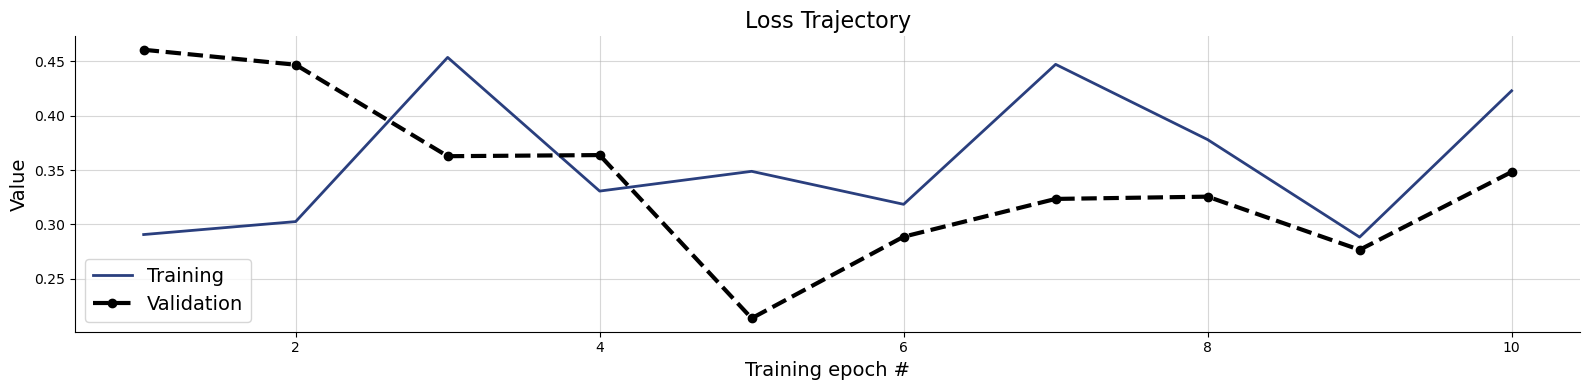

In [ ]:
# Plot the training history. The consistency loss is not very informative on its own
f = bf.diagnostics.plots.loss(history)

## Validation Phase

At this point you should validate the computational faithfulness of your trained approximator and check its performance *in silico*. As a reminder, this is not feasible with ABC, as we would have to re-run the fitting for every new data set. With `BayesFlow`, we can simply simulate new data sets and check parameter recoverability and calibration over the entire prior predictive space the network was trained on.

In [30]:
# Set the number of posterior draws you want to get
num_samples = 1000

# Simulate 300 scenarios and extract simulations and ground truth parameters
test_sims = workflow.simulate(300)
test_sims_params = {k: v for k, v in test_sims.items() if k in prior.keys()}
test_sims_data = {k: v for k, v in test_sims.items() if k not in prior.keys()}

# Obtain 1000 samples
samples = workflow.sample(conditions=test_sims_data, num_samples=num_samples)

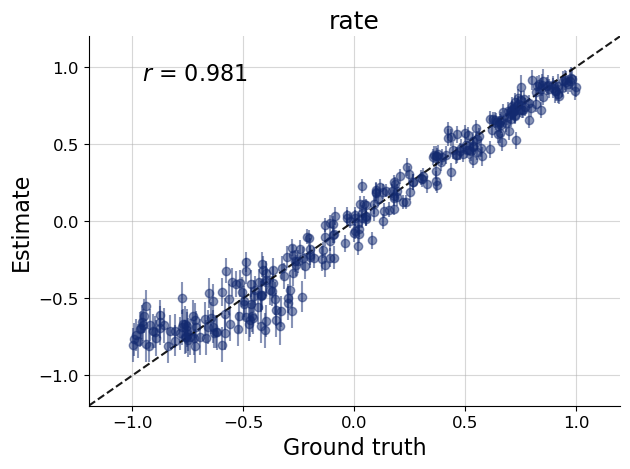

In [31]:
f = bf.diagnostics.plots.recovery(samples, test_sims_params)

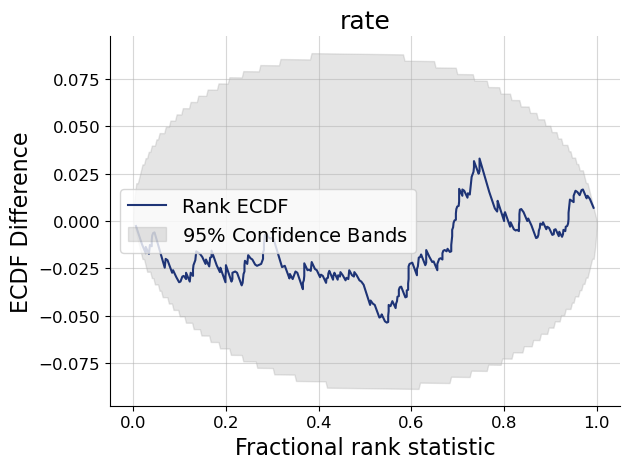

In [32]:
f = bf.diagnostics.plots.calibration_ecdf(samples, test_sims_params, difference=True)

## Inference Phase
Once the approximator has passed all consistency checks, we can now go ahead and apply it to the data of interest! For this single dataset, we can compare the posterior samples obtained from `BayesFlow` to the ones obtained from `pyABC`.

In [ ]:
# We bring the observation into the right format
xt_ind = np.searchsorted(observations["t"], t_test_times) - 1
obs = observations["X"][:, 1][xt_ind]

# Obtain 1000 posterior samples
samples = workflow.sample(conditions={'obs': [obs]}, num_samples=num_samples)

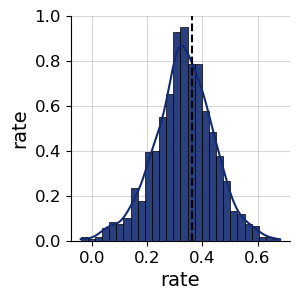

In [ ]:
f = bf.diagnostics.plots.pairs_posterior(samples, targets=np.array([true_rate]))

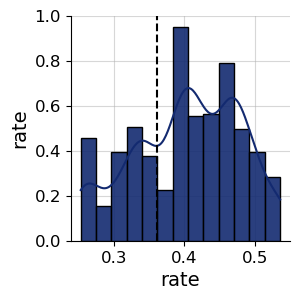

In [ ]:
# abc gives us weighted samples, we resample them to get comparable samples
df, w = abc_history.get_distribution()
abc_samples = weighted_statistics.resample(df['rate'].values, w, 1000)

f = bf.diagnostics.plots.pairs_posterior({'rate': abc_samples}, targets=np.array([true_rate]))

We can see, that the total number of simulations in ABC run is way higher (~10x) than in `BayesFlow`. Furthermore, using ABC, we can only obtain the posterior distribution for one dataset. With `BayesFlow`, we can easily infer parameters on new data sets, thereby amortizing the cost of training the approximator.

Number of simulations in BayesFlow: 64000
Number of simulations in ABC: 610620


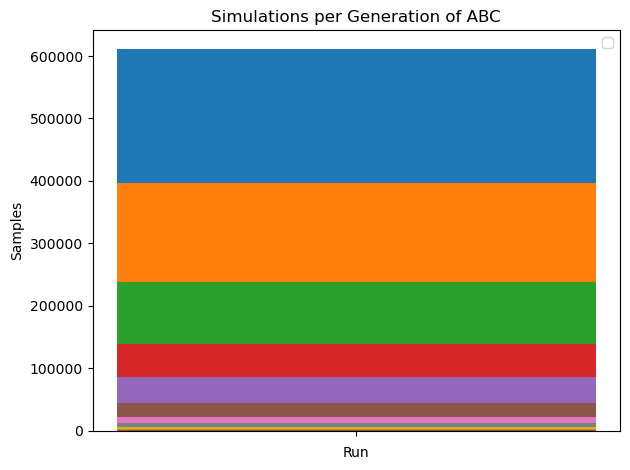

In [ ]:
print(f"Number of simulations in BayesFlow: {epochs*num_batches_per_epoch*batch_size}")
print(f"Number of simulations in ABC: {abc_history.total_nr_simulations}")

ax = plot_sample_numbers(abc_history)
ax.legend([])
ax.set_title("Simulations per Generation of ABC")
plt.show()

We have yet to fully explore the potential of amortized inference. For higher-dimensional problems, we can train a summary network jointly with the inference network, eliminating the need to manually design summary statistics as required in ABC. Additionally, the trained approximator can be seamlessly transferred to new datasets, enabling inference without retraining. Even in this simple example, we see that training the approximator required fewer simulations than running the ABC, which is particularly beneficial for computationally expensive simulators.
